In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from torch import nn
import numpy as np
import torch
import os
import sys
from tqdm import tqdm as tqdm
from IPython import display
from util import get_number_of_parameters, get_accuracy, set_random_seeds
import vgg

In [3]:
num_workers = 4

batch_size = 128
default_learning_rate = 0.1

In [4]:
# add our package dir to path
module_path = os.path.dirname(os.getcwd())
sys.path.append(module_path)

home_path = module_path
figures_path = os.path.join(home_path, 'reports', 'figures')
models_path = os.path.join(home_path, 'reports', 'models')

In [5]:
device_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(device_id)

device = torch.device("cuda:{}".format(device_id) if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device_id))

cuda:0
NVIDIA GeForce RTX 3090 Ti


In [6]:
from data import get_cifar_loader

In [7]:
train_loader = get_cifar_loader(batch_size=batch_size, train=True)
val_loader = get_cifar_loader(batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


tensor([[[-0.3333, -0.2314, -0.2000,  ..., -0.1137, -0.1529, -0.2314],
         [-0.2706, -0.1216,  0.0039,  ..., -0.0353, -0.1059, -0.1294],
         [-0.1529, -0.0510,  0.1216,  ...,  0.1059,  0.0196,  0.0118],
         ...,
         [-0.4118, -0.3255, -0.3333,  ..., -0.2314, -0.3098, -0.4510],
         [-0.1922, -0.1843, -0.1922,  ..., -0.4118, -0.3412, -0.3412],
         [-0.3647, -0.2863, -0.2235,  ..., -0.0510, -0.0588, -0.0902]],

        [[-0.1059, -0.0196, -0.0196,  ...,  0.1294,  0.0980,  0.0196],
         [-0.0588,  0.0588,  0.1608,  ...,  0.1843,  0.1137,  0.0902],
         [ 0.0196,  0.1059,  0.2784,  ...,  0.3020,  0.2157,  0.2078],
         ...,
         [-0.2941, -0.2078, -0.2157,  ..., -0.1373, -0.2000, -0.3255],
         [-0.0745, -0.0667, -0.0745,  ..., -0.3255, -0.2392, -0.2314],
         [-0.2471, -0.1686, -0.1059,  ...,  0.0196,  0.0275,  0.0118]],

        [[ 0.0431,  0.1294,  0.1451,  ...,  0.2392,  0.2078,  0.1294],
         [ 0.0510,  0.1843,  0.2941,  ...,  0

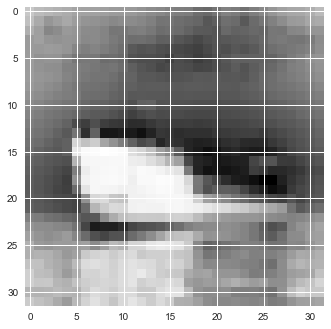

In [8]:
for X,y in train_loader:
    print(X[0])
    print(y[0])
    print(X[0].shape)
    plt.imshow(np.array(X[0,0,:,:]))
    print(X[0].max())
    print(X[0].min())
    break

In [9]:
model = vgg.VGGA()
print('Number of parameters: ', get_number_of_parameters(model))

Number of parameters:  9750922


In [10]:
model = vgg.VGGABatchNorm()
print('Number of parameters: ', get_number_of_parameters(model))

Number of parameters:  9758474


In [11]:
vgg_layer_5_id = 11 # in features
vgg_layer_10_id = 2 # in classifier

vgg_bn_layer_5_id = 15 # in features
vgg_bn_layer_10_id = 3 # in classifier

In [12]:
def get_vgg_weights(model):
    # features submodule
    features_weights = []
    features_bias = []
    # classifier submodule
    classifier_weights = []
    classifier_bias = []

    for i in range(len(model.features)):
        m = model.features[i]
        if hasattr(m, 'weight'):
            features_weights.append(m.weight.data.clone())
        if hasattr(m, 'bias'):
            features_bias.append(m.bias.data.clone())

    for i in range(len(model.classifier)):
        m = model.classifier[i]
        if hasattr(m, 'weight'):
            classifier_weights.append(m.weight.data.clone())
        if hasattr(m, 'bias'):
            classifier_bias.append(m.bias.data.clone())

    weights = features_weights, features_bias, classifier_weights, classifier_bias

    return weights


def set_vgg_weights(model, weights, feature_border=None, classifier_border=None):
    features_weights, features_bias, classifier_weights, classifier_bias = weights

    weight_idx = 0
    bias_idx = 0
    for i in range(len(model.features)):
        if feature_border == i:
            return

        m = model.features[i]
        if hasattr(m, 'weight'):
            m.weight.data = features_weights[weight_idx]
            weight_idx += 1
        if hasattr(m, 'bias'):
            m.bias.data = features_bias[bias_idx]
            bias_idx += 1

    weight_idx = 0
    bias_idx = 0
    for i in range(len(model.classifier)):
        if classifier_border == i:
            return

        m = model.classifier[i]
        if hasattr(m, 'weight'):
            m.weight.data = classifier_weights[weight_idx]
            weight_idx += 1
        if hasattr(m, 'bias'):
            m.bias.data = classifier_bias[bias_idx]
            bias_idx += 1
    return

In [13]:
def train_calculate_ICS(model,
                        optimizer,
                        criterion,
                        train_loader,
                        val_loader,
                        epochs_n,
                        layer_5_id,
                        layer_10_id):
    """
    Calculates ICS for layers 5 (Conv2d) and 10 (Linear)
    """

    batches_n = len(train_loader)
    batches_total = batches_n * epochs_n


    model.to(device)
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    # here loss gradients for layers will be stored
    G_5 = [np.nan] * batches_total
    G_5_new = [np.nan] * batches_total
    G_10 = [np.nan] * batches_total
    G_10_new = [np.nan] * batches_total

    # here ICS results will be stored
    l2_diff_5 = [np.nan] * batches_total
    l2_diff_10 = [np.nan] * batches_total

    batches_n = len(train_loader)

    for epoch in tqdm(range(epochs_n), unit='epoch'):
        model.train()

        learning_curve[epoch] = 0
        for batch, data in enumerate(train_loader):
            step_num = epoch * batches_n + batch

            x, y = data
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()

            # experiment's core

            # save weights
            current_weights = get_vgg_weights(model)
            G_5 = model.features[layer_5_id].weight.grad.cpu().clone()
            G_10 = model.classifier[layer_10_id].weight.grad.cpu().clone()

            # perform optimizer's step
            optimizer.step()

            # save new weights
            new_weights = get_vgg_weights(model)

            # for layer 5
            set_vgg_weights(model, current_weights)
            set_vgg_weights(model, new_weights, feature_border=layer_5_id)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            G_5_new = model.features[layer_5_id].weight.grad.cpu().clone()

            # for layer 10
            set_vgg_weights(model, new_weights, classifier_border=layer_10_id)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            loss.backward()
            G_10_new = model.classifier[layer_10_id].weight.grad.cpu().clone()

            # set all weights to new
            set_vgg_weights(model, new_weights)

            # calculate ICS results
            l2_diff_5[step_num] = torch.norm(G_5 - G_5_new, 2)
            l2_diff_10[step_num] = torch.norm(G_10 - G_10_new, 2)

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)

        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch

        axes[1].set_title('Train {:.4f}, val {:.4f}, max val {:.4f} at {}'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)

        plt.tight_layout()
        plt.show()
    print('Experiment finished')

    return learning_curve, train_accuracy_curve, val_accuracy_curve, l2_diff_5, l2_diff_10

In [14]:
training_results = {}

In [15]:
lr = 0.0005

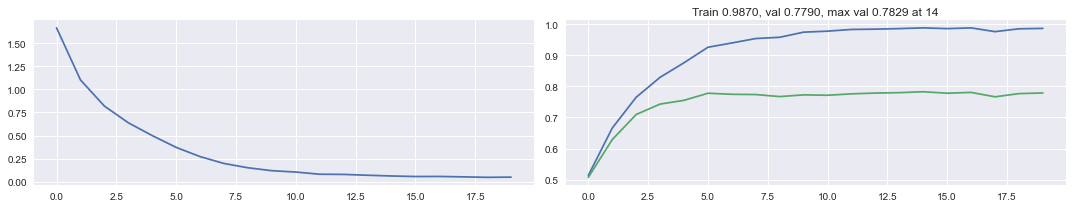

100%|██████████| 20/20 [14:07<00:00, 42.37s/epoch]

Experiment finished


In [16]:
model_name = 'VGG'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_layer_5_id,
                                                         layer_10_id=vgg_layer_10_id)

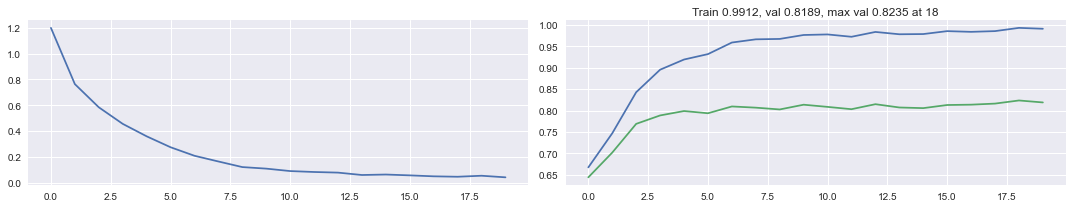

100%|██████████| 20/20 [14:22<00:00, 43.14s/epoch]

Experiment finished


In [17]:
model_name = 'VGG_BN'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_bn_layer_5_id,
                                                         layer_10_id=vgg_bn_layer_10_id)

In [18]:
lr = 0.003

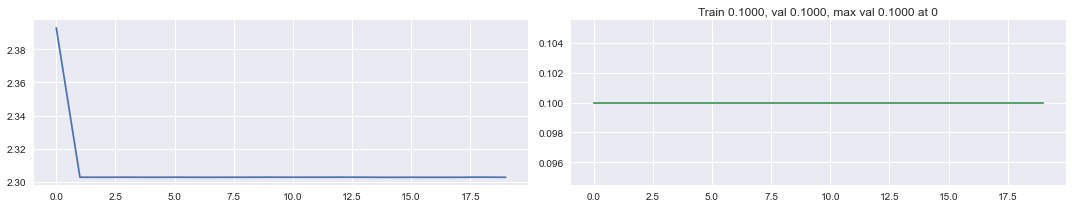

100%|██████████| 20/20 [12:55<00:00, 38.79s/epoch]

Experiment finished


In [19]:
model_name = 'VGG'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGA()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_layer_5_id,
                                                         layer_10_id=vgg_layer_10_id)

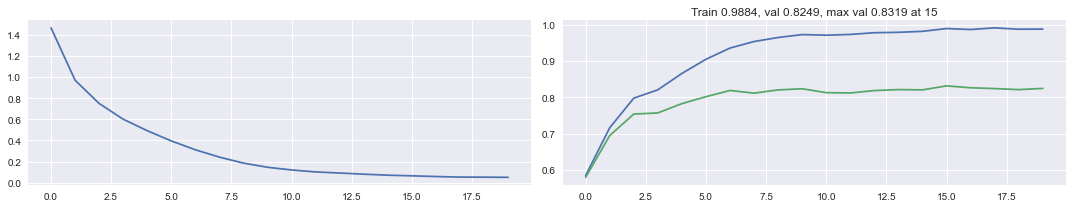

100%|██████████| 20/20 [13:55<00:00, 41.76s/epoch]

Experiment finished


In [20]:
model_name = 'VGG_BN'
experimment_name = f'{model_name}_lr_{lr}'

set_random_seeds(seed_value=1984, device=device)
model = vgg.VGGABatchNorm()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

training_results[experimment_name] = train_calculate_ICS(model,
                                                         optimizer,
                                                         criterion,
                                                         train_loader,
                                                         val_loader,
                                                         epochs_n=20,
                                                         layer_5_id=vgg_bn_layer_5_id,
                                                         layer_10_id=vgg_bn_layer_10_id)

In [21]:
experiments = [name for name in training_results.keys()]
print(experiments)

['VGG_lr_0.0005', 'VGG_BN_lr_0.0005', 'VGG_lr_0.003', 'VGG_BN_lr_0.003']


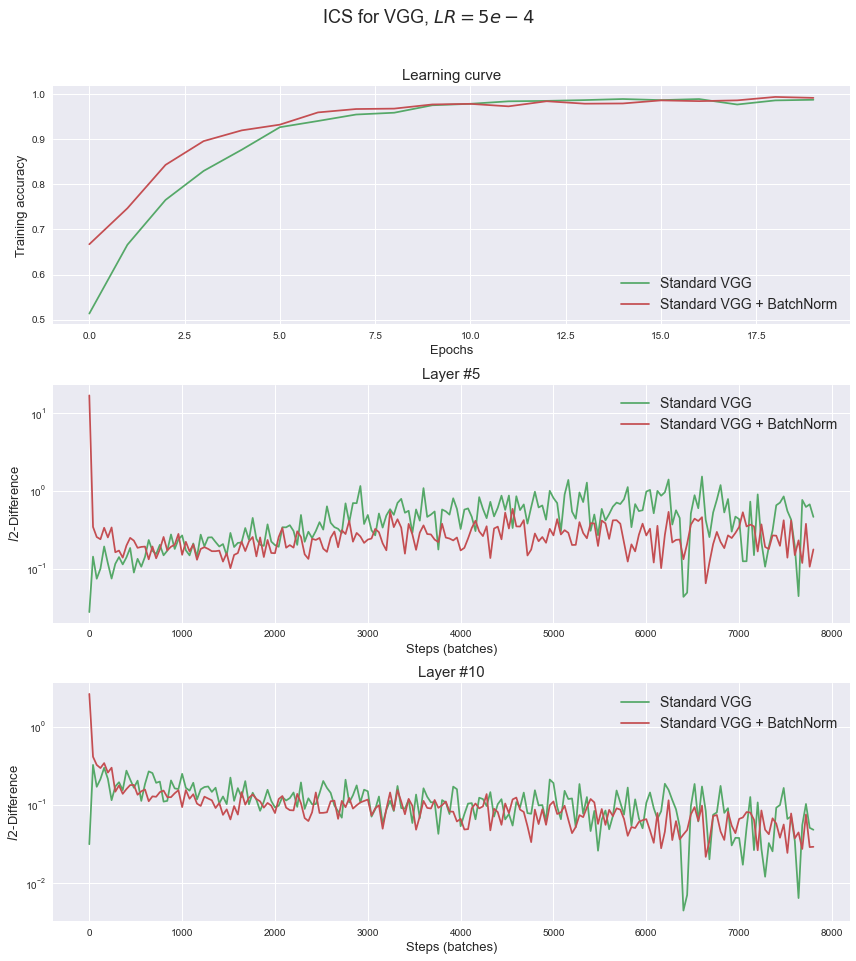

In [25]:
start_from = 0
step = 40
total_steps_n = len(training_results['VGG_lr_0.0005'][3])
steps_for_plot = np.arange(start_from, total_steps_n, step)

# first learning rate
fig, axs = plt.subplots(3, 1, figsize=(12, 14))
fig.suptitle('ICS for VGG, $LR = 5e-4$', fontsize=18)

curr_exper = 'VGG_lr_0.0005'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C1', label='Standard VGG')
axs[i].set_title('Learning curve', fontsize=15)
axs[i].set_ylabel('Training accuracy', fontsize=13)
axs[i].set_xlabel('Epochs', fontsize=13)
i = 1
axs[i].semilogy(steps_for_plot, curr_results[3][start_from::step], color='C1', label='Standard VGG')
axs[i].set_title('Layer #5', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)
i = 2
axs[i].semilogy(steps_for_plot, curr_results[4][start_from::step], color='C1', label='Standard VGG')
axs[i].set_title('Layer #10', fontsize=15)
axs[i].set_ylabel('$l2$-Difference', fontsize=13)
axs[i].set_xlabel('Steps (batches)', fontsize=13)

curr_exper = 'VGG_BN_lr_0.0005'
curr_results = training_results[curr_exper]
i = 0
axs[i].plot(curr_results[1], color='C2', label='Standard VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 1
axs[i].semilogy(steps_for_plot, curr_results[3][start_from::step], color='C2', label='Standard VGG + BatchNorm')
axs[i].legend(fontsize=14)
i = 2
axs[i].semilogy(steps_for_plot, curr_results[4][start_from::step], color='C2', label='Standard VGG + BatchNorm')
axs[i].legend(fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('ICS_l2_VGG_LR_5e-4.png', dpi=300, quality=100)
plt.show()



KeyError: 'VGG_lr_0.001'

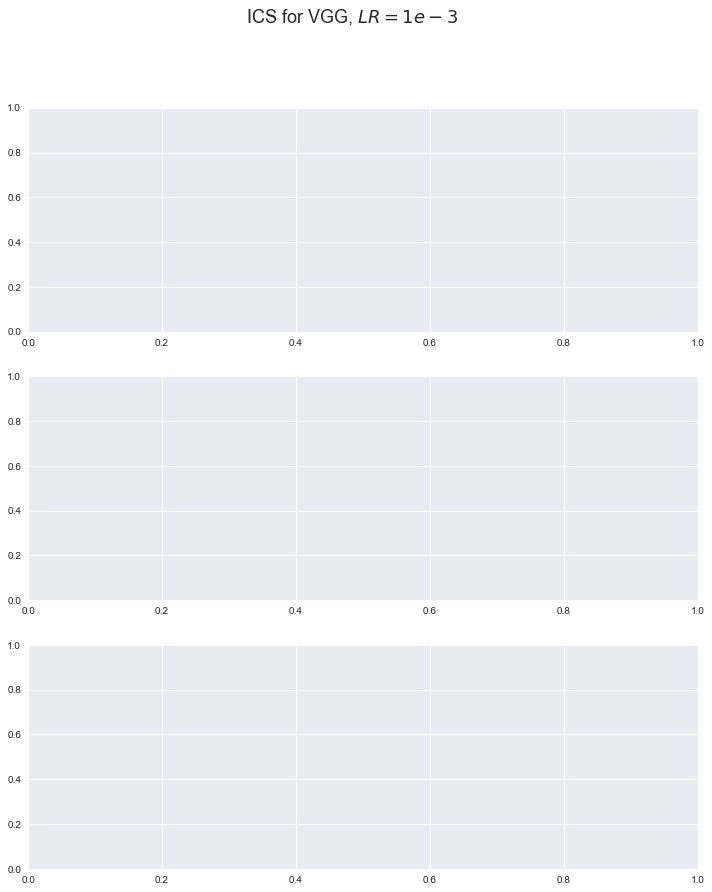

In [26]:
# # second learning rate
# fig, axs = plt.subplots(3, 1, figsize=(12, 14))
# fig.suptitle('ICS for VGG, $LR = 1e-3$', fontsize=18)
#
# curr_exper = 'VGG_lr_0.001'
# curr_results = training_results[curr_exper]
# i = 0
# axs[i].plot(curr_results[1], color='C1', label='Standard VGG')
# axs[i].set_title('Learning curve', fontsize=15)
# axs[i].set_ylabel('Training accuracy', fontsize=13)
# axs[i].set_xlabel('Epochs', fontsize=13)
# i = 1
# axs[i].semilogy(steps_for_plot, curr_results[3][start_from::step], color='C1', label='Standard VGG')
# axs[i].set_title('Layer #5', fontsize=15)
# axs[i].set_ylabel('$l2$-Difference', fontsize=13)
# axs[i].set_xlabel('Steps (batches)', fontsize=13)
# i = 2
# axs[i].semilogy(steps_for_plot, curr_results[4][start_from::step], color='C1', label='Standard VGG')
# axs[i].set_title('Layer #10', fontsize=15)
# axs[i].set_ylabel('$l2$-Difference', fontsize=13)
# axs[i].set_xlabel('Steps (batches)', fontsize=13)
#
# curr_exper = 'VGG_BN_lr_0.001'
# curr_results = training_results[curr_exper]
# i = 0
# axs[i].plot(curr_results[1], color='C2', label='Standard VGG + BatchNorm')
# axs[i].legend(fontsize=14)
# i = 1
# axs[i].semilogy(steps_for_plot, curr_results[3][start_from::step], color='C2', label='Standard VGG + BatchNorm')
# axs[i].legend(fontsize=14)
# i = 2
# axs[i].semilogy(steps_for_plot, curr_results[4][start_from::step], color='C2', label='Standard VGG + BatchNorm')
# axs[i].legend(fontsize=14)
#
# fig.tight_layout(rect=[0, 0.03, 1, 0.96])
# plt.savefig('ICS_l2_VGG_LR_1e-3.png', dpi=300, quality=100)
# plt.show()